Weighting objective functions-based method

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

In [2]:
random.seed(42)
np.random.seed(42)
df = pd.read_csv('data.csv')
x_coords = df['XCOORD'].tolist()
y_coords = df['YCOORD'].tolist()
profit = [random.randint(1, 50) for _ in range(101)]
num_customers = len(df)
distance_matrix = np.zeros((num_customers, num_customers))

for i in range(num_customers):
    for j in range(num_customers):
        if i != j:
            distance_matrix[i][j] = np.sqrt((x_coords[i] - x_coords[j]) ** 2 + (y_coords[i] - y_coords[j]) ** 2)

In [3]:
def calculate_profit(individual):
    profit_sum = 0
    for order, index in enumerate(individual):
      profit_sum += profit[index] * (1 - order / 100)
    return profit_sum

def calculate_distance(individual):
    total_distance = 0
    for i in range(len(individual) - 1):
        total_distance += distance_matrix[individual[i]][individual[i + 1]]
    total_distance += distance_matrix[individual[-1]][individual[0]]
    return total_distance

def evaluate_tsp(individual, lamda):
    total_distance = calculate_distance(individual)
    total_profit = calculate_profit(individual)
    return total_distance - lamda * total_profit,

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_customers), num_customers)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
lamda = 1.2
toolbox.register("evaluate", evaluate_tsp, lamda=lamda)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=800)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

gen, max_gen = 0, 1000
while gen < max_gen:
    gen += 1
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring + population, k=len(population))
    hof.update(population)
    best = tools.selBest(population, k=1)[0]
    best_obj = evaluate_tsp(best, lamda)[0]
    if gen % 200 == 0:
        print(f"generation {gen}, best: {best_obj}, {calculate_distance(best)}, {calculate_profit(best)}")

E:\Anaconda3\envs\torch\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
E:\Anaconda3\envs\torch\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


generation 200, best: -671.1303009447875, 1116.2216990552126, 1489.46
generation 400, best: -847.8153830587611, 987.8246169412395, 1529.7000000000005
generation 600, best: -901.3295757269385, 949.8144242730624, 1542.6200000000008
generation 800, best: -907.6539777692703, 937.1180222307298, 1537.3100000000002
generation 1000, best: -962.1756472502981, 889.8563527497025, 1543.3600000000006


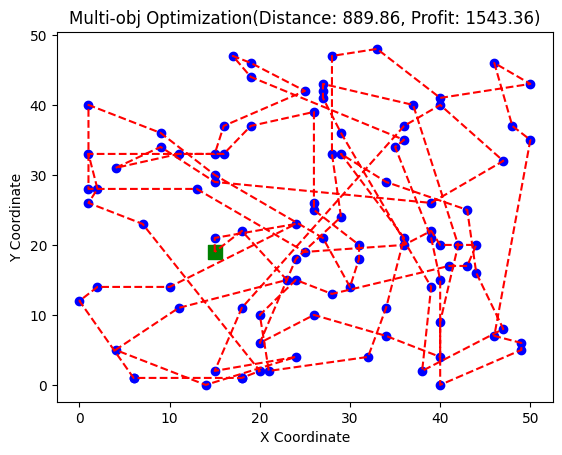

In [9]:
optimized_path = list(best)

optimized_x = [x_coords[i] for i in optimized_path]
optimized_y = [y_coords[i] for i in optimized_path]

optimized_x.append(optimized_x[0])
optimized_y.append(optimized_y[0])

# Plot the path
plt.scatter(optimized_x, optimized_y, marker='o', color='b')
plt.plot(optimized_x, optimized_y, linestyle='dashed', color='r')
plt.scatter(optimized_x[0], optimized_y[0], marker='s', color='g', s=100, label='Start')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Multi-obj Optimization(Distance: {calculate_distance(best):.2f}, Profit: {calculate_profit(best):.2f})')
plt.savefig("fig9.png")
plt.show()